# Benchmark Analysis - H8

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
from pathlib import Path
from typing import List, Dict, Any, Tuple, Optional

%matplotlib inline

In [3]:
matplotlib.style.use('seaborn-v0_8')  

In [4]:
device_name = 'nebulac'
core_list = [1,2,4,8,16,32,64]

In [5]:
root_dir = '/Users/diego/Desktop/BENCHMARK_NEBULAC_ALL_67M_WITH_BYTES'

In [6]:
GCC_TBB_COLOR = 'salmon'
GCC_TBB_COLOR_SECONDARY = 'sienna'

NVC_OMP_COLOR = 'green'
NVC_OMP_COLOR_SECONDARY = 'yellowgreen'

NVC_GPU_COLOR = 'brown'


In [7]:
plot_save_dir = './plots/h8'

## Utils 

In [8]:
def get_path(*entries):
    return os.path.join(*entries)

In [9]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [10]:
def plot(name:str,save=True) -> None:
    name = name.replace(' ','-')
    if save:
        plt.savefig(get_path(plot_save_dir,name+".png"),bbox_inches='tight')
    plt.show()

In [11]:
def extraction_pandas_frame_algo(path, COMP="TODO",include_bytes_per_second=False):
    df = pd.read_csv(path)

    # dropping columns we do not care about
    df = df.drop(['iterations', 'items_per_second', 'label', 'error_occurred', 'error_message'],
                    axis=1)

    if not include_bytes_per_second:
        df = df.drop(columns=['bytes_per_second'])

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean', 'median', 'stddev','max','min'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/') + 1:x[0].rfind('_')], axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'], ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C'] * 5 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C'] * 5 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])

    # set max bytes per second
    results_gcc['max_id'] = results_gcc['C'] * 5 + 3
    
    # max bytes per seconds as bytes per second
    if include_bytes_per_second:
        results_gcc['bytes_per_second'] = results_gcc['max_id'].apply(lambda x: df.iloc[x]['bytes_per_second'])

    # min time as real_time
    results_gcc['min_id'] = results_gcc['C'] * 5 + 4
    results_gcc['real_time'] = results_gcc['min_id'].apply(lambda x: df.iloc[x]['real_time'])


    results_gcc = results_gcc.drop(['C', 'median_id', 'stddev_id','min_id','max_id'], axis=1)
    results_gcc['Compiler'] = 'COMP'
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']), "").replace('/_mean', ''), axis=1)

    return results_gcc


In [12]:
# generate filename for threading
def get_threading_file_name(benchmark_name:str, thread_nr: int, input_size:str) -> str:
    return f"[T{thread_nr}]_{benchmark_name}_{input_size}_T{thread_nr}.csv"

# extract threaded into dictionary
def extraction_pandas_frame_algo_threaded(folder_path:str, benchmark_name:str, threads_list:List[int], input_size:int = '67108864', COMP:str="TODO") -> Any:
    result = pd.DataFrame()

    for t_id in threads_list:
        filename = get_threading_file_name(benchmark_name=benchmark_name,thread_nr=t_id,input_size=input_size)
        file_path = get_path(folder_path,filename)
        
        data_frame = extraction_pandas_frame_algo(file_path,COMP=COMP)
        data_frame['threads'] = t_id
        result = pd.concat([result, data_frame], ignore_index=True)


    result = result.rename_axis(None, axis=1)
    return result

In [13]:
# calculate speedup based on seq runnings
def calc_speedup_based_seq(seq_df: pd.DataFrame, threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    # calculate speedup
    seq_df = seq_df[seq_df['n'] == input_size]
    seq_time = seq_df['real_time'].iloc[0] # now its only a single digit

    threads_df['speedup'] = seq_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [14]:
def calc_speedup_based_par(threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    base_time = threads_df[threads_df['threads'] == 1].iloc[0]['real_time']
    
    threads_df['speedup'] = base_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [15]:
def par_data_algo(compiler_location:str,compiler_name:str,bench_name:str) -> pd.DataFrame:
    # load bench_name
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/{bench_name}_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df

In [16]:
def get_seq_base(benchmark_name:str) -> pd.DataFrame:

    time_filed_name = 'real_time'

    compiler_instances = [
        ('GCC_TBB','GCC(TBB)'),
        ('NVHPC_Multicore','NVC(OMP)')
    ]

    start_df = extraction_pandas_frame_algo(f'{root_dir}/{compiler_instances[0][0]}/DEFAULT/{benchmark_name}_seq__Default.csv')
    min_val = start_df[time_filed_name].min()
    min_df = start_df


    for i in range(1,len(compiler_instances)):
        current_df = extraction_pandas_frame_algo(f'{root_dir}/{compiler_instances[i][0]}/DEFAULT/{benchmark_name}_seq__Default.csv')
        current_min = current_df[time_filed_name].min()

        if current_min < min_val:
            min_val = current_min
            min_df = current_df

    return min_df

In [17]:
def get_strong_scaling_algo(compiler_location:str,compiler_name:str,bench_name:str,base_of:Optional[str]=None) -> pd.DataFrame:
    
    if base_of is None:
        ## seq base
        seq_base = get_seq_base(bench_name)
    else:
        seq_base = get_seq_base(base_of)

    
    ## threaded
    df = extraction_pandas_frame_algo_threaded(f'{root_dir}/{compiler_location}/THREADS',
                                               f'{bench_name}_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")

# H8

> Parallel STL does not inherently provide support for index-based iterations, thereby requiring the developer to devise
> a custom sequence for indices. The manner in which the index values are generated by the developer can significantly
> impact the application's performance and scalability.

## `b9_1_transform_baseline`

In [18]:
benchmark_name = "b9_1_transform_baseline"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b9_1_transform_baseline`

Check how the runtime without constraining the threads develops with increasing input size

In [19]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b9_1_transform_baseline_time_merged = pd.merge(*data, on='n')

b9_1_transform_baseline_time_merged

,GCC(TBB),n,NVC(OMP)
0,5312.93,4,12703.4
1,12049.20,8,12673.2
2,18309.20,16,12583.2
3,22984.20,32,13002.2
4,26305.90,64,14035.1
5,27720.60,128,13608.5
6,30121.10,256,13522.9
7,32911.60,512,13678.2
8,36899.30,1024,13893.7
9,41922.80,2048,13419.9


### Strong Scaling - `b9_1_transform_baseline`
 
2^26 fixed input size with threads 1-64

In [20]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b9_1_transform_baseline_strong_scaling_merged = pd.merge(*data, on='threads')

b9_1_transform_baseline_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.037489,0.115081
1,2,1.344101,0.229680
2,4,3.115655,0.459002
3,8,2.827470,0.916374
4,16,4.488336,1.830057
5,32,4.723968,3.646567
6,64,4.917287,7.255719


In [21]:
## efficiency graph

b9_1_transform_baseline_efficiency = b9_1_transform_baseline_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b9_1_transform_baseline_efficiency[f'{compiler_name}'] = b9_1_transform_baseline_efficiency[f'{compiler_name}'] / b9_1_transform_baseline_efficiency['threads']



b9_1_transform_baseline_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.037489,0.115081
1,2,0.672050,0.114840
2,4,0.778914,0.114751
3,8,0.353434,0.114547
4,16,0.280521,0.114379
5,32,0.147624,0.113955
6,64,0.076833,0.113371


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_8303/678994611.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


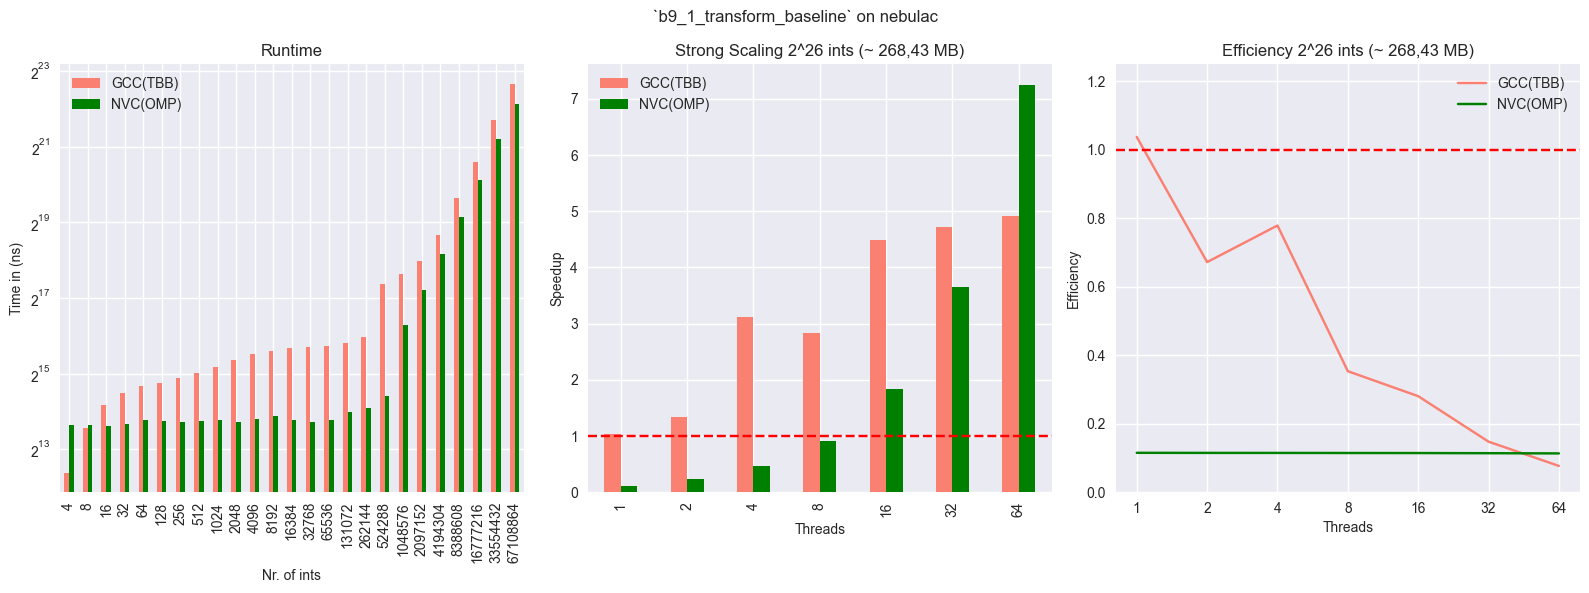

In [22]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b9_1_transform_baseline_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b9_1_transform_baseline_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b9_1_transform_baseline_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b9_1_transform_baseline` on {device_name}")

fig.tight_layout()

plot(f"`b9_1_transform_baseline` {device_name}")

## `b9_2_transform_old_iota`

In [23]:
benchmark_name = "b9_2_transform_old_iota"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b9_2_transform_old_iota`

Check how the runtime without constraining the threads develops with increasing input size

In [24]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b9_2_transform_old_iota_time_merged = pd.merge(*data, on='n')

b9_2_transform_old_iota_time_merged

,GCC(TBB),n,NVC(OMP)
0,6.743520e+03,4,11096.3
1,1.183130e+04,8,10848.6
2,1.895510e+04,16,11614.1
3,2.375960e+04,32,12547.0
4,2.713470e+04,64,13486.8
5,2.931870e+04,128,12876.2
6,3.345490e+04,256,12984.0
7,3.887160e+04,512,17241.5
8,4.465420e+04,1024,17437.5
9,5.316910e+04,2048,21882.3


### Strong Scaling - `b9_2_transform_old_iota`
 
2^26 fixed input size with threads 1-64

In [25]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b9_2_transform_old_iota_strong_scaling_merged = pd.merge(*data, on='threads')

b9_2_transform_old_iota_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.002025,0.485481
1,2,1.129635,0.741628
2,4,1.233146,0.996137
3,8,1.232190,1.160965
4,16,1.114002,1.148339
5,32,1.134073,1.124022
6,64,1.126075,1.136196


In [26]:
## efficiency graph

b9_2_transform_old_iota_efficiency = b9_2_transform_old_iota_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b9_2_transform_old_iota_efficiency[f'{compiler_name}'] = b9_2_transform_old_iota_efficiency[f'{compiler_name}'] / b9_2_transform_old_iota_efficiency['threads']



b9_2_transform_old_iota_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.002025,0.485481
1,2,0.564818,0.370814
2,4,0.308286,0.249034
3,8,0.154024,0.145121
4,16,0.069625,0.071771
5,32,0.035440,0.035126
6,64,0.017595,0.017753


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_8303/1659612440.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


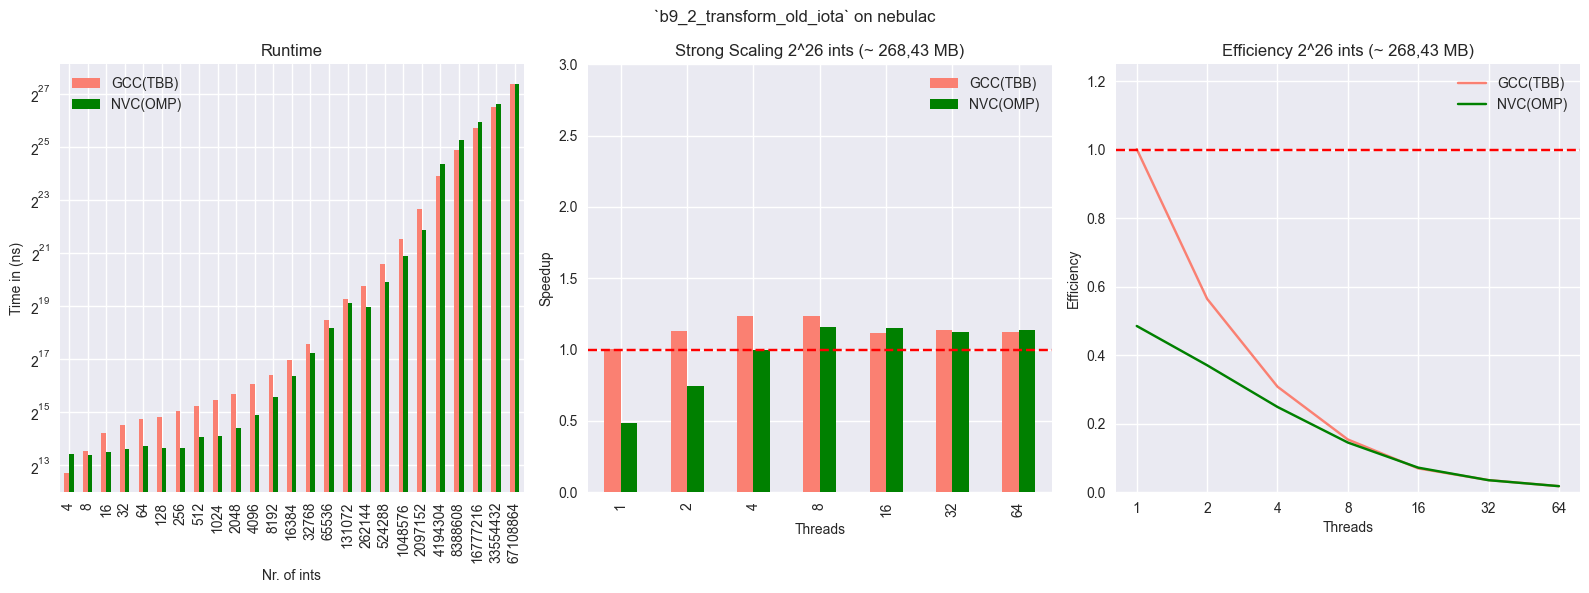

In [27]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b9_2_transform_old_iota_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b9_2_transform_old_iota_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b9_2_transform_old_iota_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b9_2_transform_old_iota` on {device_name}")

fig.tight_layout()

plot(f"`b9_2_transform_old_iota` {device_name}")

## `b9_3_transform_views_iota`

In [28]:
benchmark_name = "b9_3_transform_views_iota"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b9_3_transform_views_iota`

Check how the runtime without constraining the threads develops with increasing input size

In [29]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b9_3_transform_views_iota_time_merged = pd.merge(*data, on='n')

b9_3_transform_views_iota_time_merged

,GCC(TBB),n,NVC(OMP)
0,4.823120e+01,4,11550.6
1,4.822860e+01,8,11309.4
2,4.874440e+01,16,11544.7
3,4.999880e+01,32,12157.8
4,5.112950e+01,64,12649.4
5,7.118170e+01,128,12230.7
6,1.273190e+02,256,11793.1
7,1.943360e+02,512,11604.5
8,3.212950e+02,1024,12437.9
9,5.782310e+02,2048,11806.5


### Strong Scaling - `b9_3_transform_views_iota`
 
2^26 fixed input size with threads 1-64

In [30]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b9_3_transform_views_iota_strong_scaling_merged = pd.merge(*data, on='threads')

b9_3_transform_views_iota_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.994971,0.117466
1,2,0.988125,0.234757
2,4,0.988465,0.467345
3,8,0.857182,0.933167
4,16,0.679591,1.867088
5,32,0.657981,3.717025
6,64,0.685956,7.406513


In [31]:
## efficiency graph

b9_3_transform_views_iota_efficiency = b9_3_transform_views_iota_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b9_3_transform_views_iota_efficiency[f'{compiler_name}'] = b9_3_transform_views_iota_efficiency[f'{compiler_name}'] / b9_3_transform_views_iota_efficiency['threads']



b9_3_transform_views_iota_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.994971,0.117466
1,2,0.494063,0.117379
2,4,0.247116,0.116836
3,8,0.107148,0.116646
4,16,0.042474,0.116693
5,32,0.020562,0.116157
6,64,0.010718,0.115727


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_8303/1164897114.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


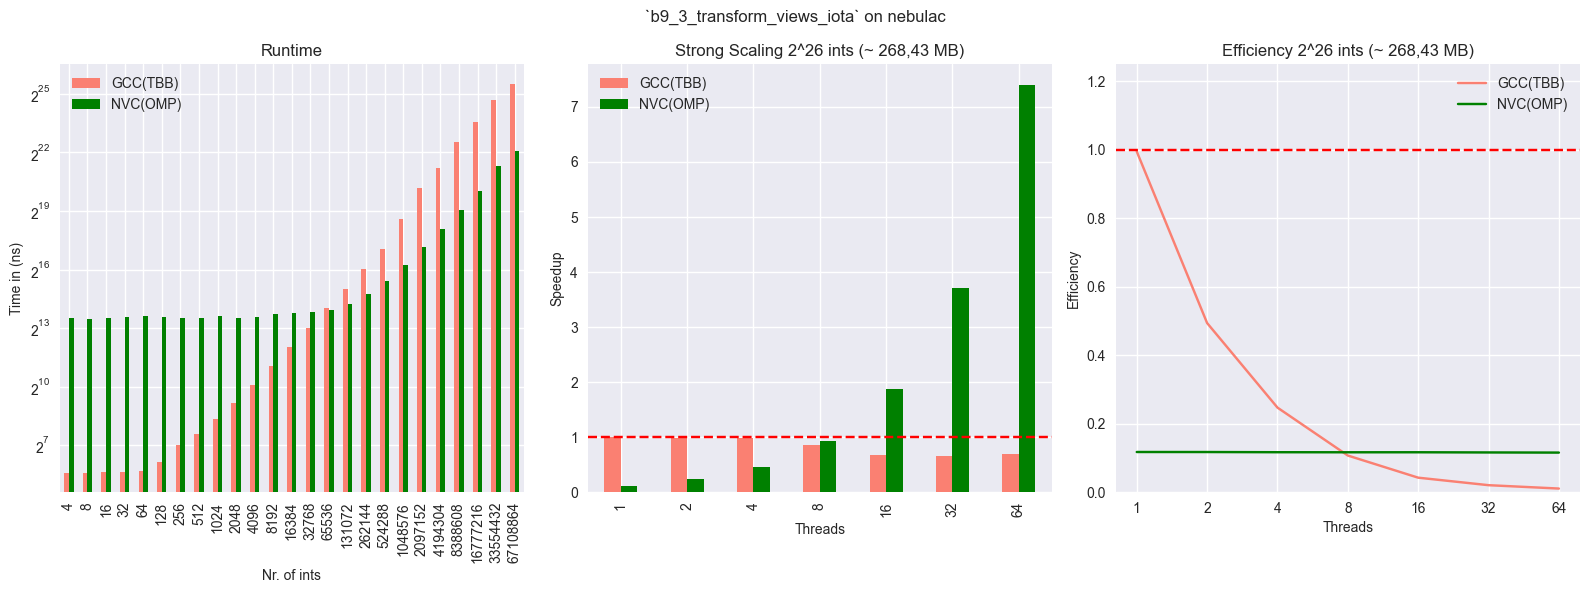

In [32]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b9_3_transform_views_iota_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b9_3_transform_views_iota_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b9_3_transform_views_iota_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b9_3_transform_views_iota` on {device_name}")

fig.tight_layout()

plot(f"`b9_3_transform_views_iota` {device_name}")

## `b9_5_transform_custom_iterator`

In [33]:
benchmark_name = "b9_5_transform_custom_iterator"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b9_5_transform_custom_iterator`

Check how the runtime without constraining the threads develops with increasing input size

In [34]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b9_5_transform_custom_iterator_time_merged = pd.merge(*data, on='n')

b9_5_transform_custom_iterator_time_merged

,GCC(TBB),n,NVC(OMP)
0,5866.79,4,11243.2
1,11288.80,8,11233.9
2,22433.80,16,10904.3
3,26572.90,32,11910.2
4,29749.40,64,13109.6
5,31169.10,128,12321.5
6,32782.70,256,12200.3
7,35092.40,512,14224.9
8,39455.50,1024,12249.3
9,44107.80,2048,11429.8


### Strong Scaling - `b9_5_transform_custom_iterator`
 
2^26 fixed input size with threads 1-64

In [35]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b9_5_transform_custom_iterator_strong_scaling_merged = pd.merge(*data, on='threads')

b9_5_transform_custom_iterator_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.987525,0.118683
1,2,1.300129,0.236771
2,4,3.048011,0.471669
3,8,3.450725,0.944085
4,16,4.422298,1.878387
5,32,4.561089,3.745439
6,64,4.835568,7.420017


In [36]:
## efficiency graph

b9_5_transform_custom_iterator_efficiency = b9_5_transform_custom_iterator_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b9_5_transform_custom_iterator_efficiency[f'{compiler_name}'] = b9_5_transform_custom_iterator_efficiency[f'{compiler_name}'] / b9_5_transform_custom_iterator_efficiency['threads']



b9_5_transform_custom_iterator_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.987525,0.118683
1,2,0.650065,0.118386
2,4,0.762003,0.117917
3,8,0.431341,0.118011
4,16,0.276394,0.117399
5,32,0.142534,0.117045
6,64,0.075556,0.115938


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_8303/2319354240.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


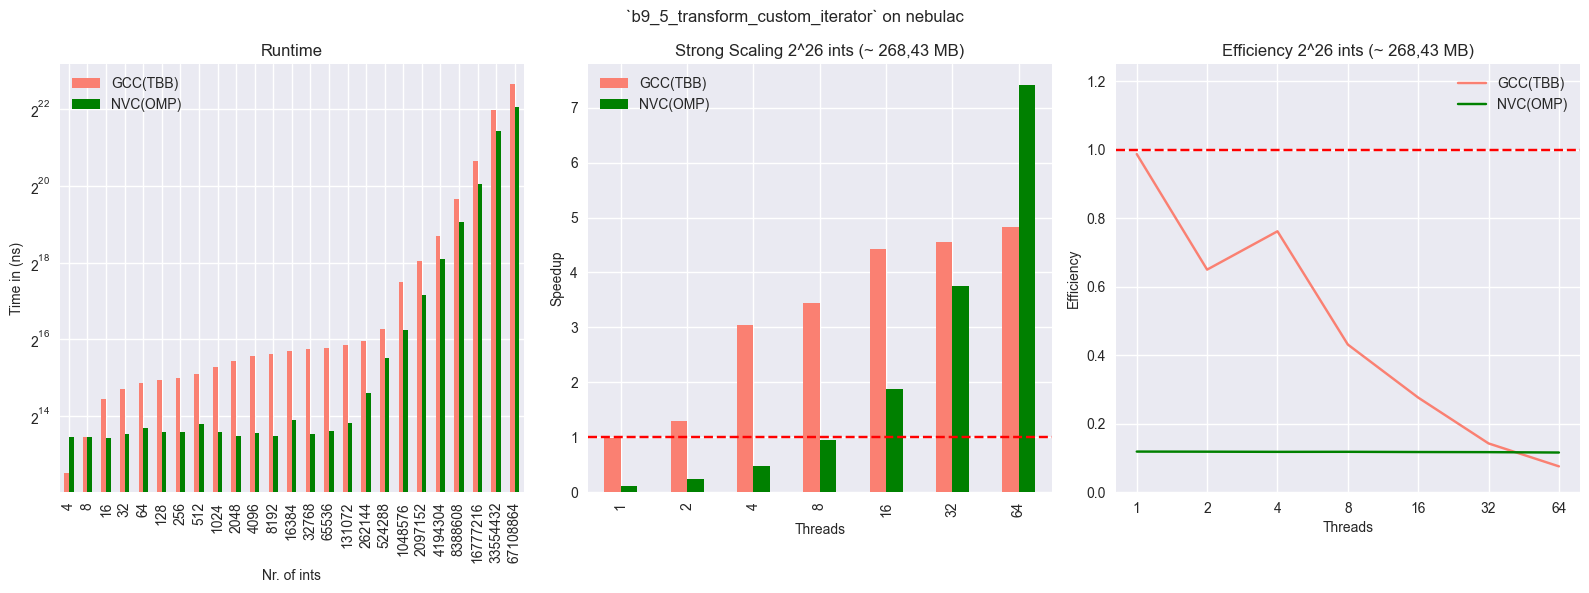

In [37]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b9_5_transform_custom_iterator_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b9_5_transform_custom_iterator_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b9_5_transform_custom_iterator_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b9_5_transform_custom_iterator` on {device_name}")

fig.tight_layout()

plot(f"`b9_5_transform_custom_iterator` {device_name}")

## `b9_6_transform_boost`

In [38]:
benchmark_name = "b9_6_transform_boost"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b9_6_transform_boost`

Check how the runtime without constraining the threads develops with increasing input size

In [39]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b9_6_transform_boost_time_merged = pd.merge(*data, on='n')

b9_6_transform_boost_time_merged

,GCC(TBB),n,NVC(OMP)
0,6806.17,4,11773.3
1,15701.80,8,11914.8
2,21616.90,16,11966.0
3,26096.40,32,13245.7
4,29642.70,64,13638.5
5,30970.70,128,13284.3
6,32453.70,256,13707.9
7,34761.80,512,12256.6
8,38274.00,1024,12681.3
9,43171.50,2048,12625.2


### Strong Scaling - `b9_6_transform_boost`
 
2^26 fixed input size with threads 1-64

In [40]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b9_6_transform_boost_strong_scaling_merged = pd.merge(*data, on='threads')

b9_6_transform_boost_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.009905,0.120434
1,2,1.332890,0.240584
2,4,3.151123,0.478394
3,8,3.884767,0.959867
4,16,4.462359,1.910619
5,32,4.730667,3.812608
6,64,4.905158,7.573869


In [41]:
## efficiency graph

b9_6_transform_boost_efficiency = b9_6_transform_boost_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b9_6_transform_boost_efficiency[f'{compiler_name}'] = b9_6_transform_boost_efficiency[f'{compiler_name}'] / b9_6_transform_boost_efficiency['threads']



b9_6_transform_boost_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.009905,0.120434
1,2,0.666445,0.120292
2,4,0.787781,0.119598
3,8,0.485596,0.119983
4,16,0.278897,0.119414
5,32,0.147833,0.119144
6,64,0.076643,0.118342


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_8303/91003008.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


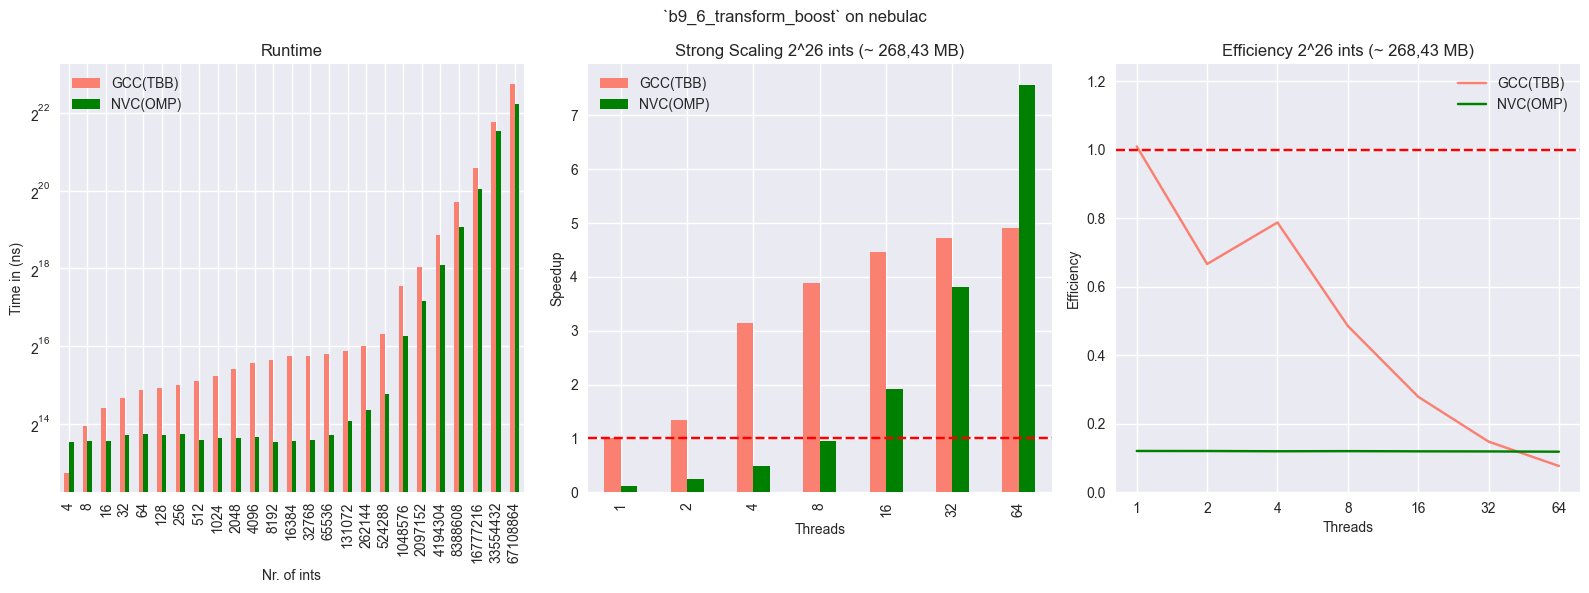

In [42]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b9_6_transform_boost_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b9_6_transform_boost_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b9_6_transform_boost_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b9_6_transform_boost` on {device_name}")

fig.tight_layout()

plot(f"`b9_6_transform_boost` {device_name}")

## Speedup comparison per strategy

In [43]:
impl_index_versions = [
    ('b9_1_transform_baseline'),
    ('b9_2_transform_old_iota'),
    ('b9_3_transform_views_iota'),
    ('b9_5_transform_custom_iterator'),
    ('b9_6_transform_boost'),
]

base_of = "b9_1_transform_baseline"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

data_index_strategies_speedup : Dict[str,pd.DataFrame] = {}
data_index_strategies_efficiency : Dict[str,pd.DataFrame] = {}

for compiler_location, compiler_name in instances:
    data = [get_strong_scaling_algo(compiler_location,bench_name,bench_name,base_of) for bench_name in impl_index_versions ]

    # speedup data collector 
    data_index_strategies_speedup[compiler_name] = data[0]

    for i in range(1,len(data)):
        data_index_strategies_speedup[compiler_name] = pd.merge(data_index_strategies_speedup[compiler_name],data[i],on='threads')

    # efficiency 
    data_index_strategies_efficiency[compiler_name] = data_index_strategies_speedup[compiler_name].copy()

    for strat in impl_index_versions:
        data_index_strategies_efficiency[compiler_name][strat] = data_index_strategies_efficiency[compiler_name][strat] / data_index_strategies_efficiency[compiler_name]['threads']

data_index_strategies_efficiency[instances[0][1]]



,threads,b9_1_transform_baseline,b9_2_transform_old_iota,b9_3_transform_views_iota,b9_5_transform_custom_iterator,b9_6_transform_boost
0,1,1.037489,0.168445,1.024388,1.017050,1.014792
1,2,0.672050,0.094948,0.508670,0.669500,0.669670
2,4,0.778914,0.051824,0.254422,0.784785,0.791592
3,8,0.353434,0.025892,0.110316,0.444237,0.487945
4,16,0.280521,0.011704,0.043730,0.284657,0.280247
5,32,0.147624,0.005958,0.021170,0.146796,0.148549
6,64,0.076833,0.002958,0.011035,0.077815,0.077014


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_8303/2214280357.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_8303/2214280357.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


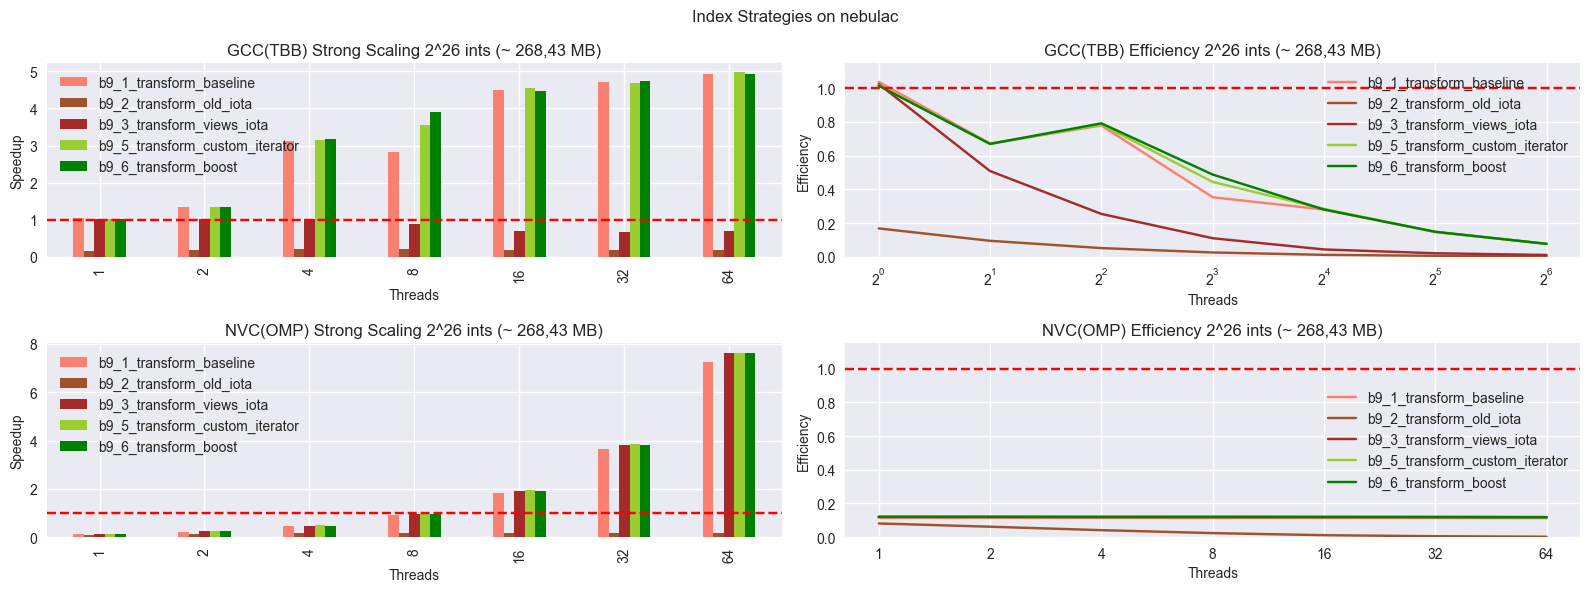

In [44]:
# graphs 

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16, 6))


# plot strong scaling
ax_2 = data_index_strategies_speedup['GCC(TBB)'].plot(kind='bar',
                                                                    x='threads',
                                                                    align='center',
                                                                    color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_GPU_COLOR,NVC_OMP_COLOR_SECONDARY,NVC_OMP_COLOR],
                                                                    ax=axes[0,0]
                                                                    )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('GCC(TBB) Strong Scaling 2^26 ints (~ 268,43 MB)')




# plot efficiency
ax_3 = data_index_strategies_efficiency['GCC(TBB)'].plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_GPU_COLOR,NVC_OMP_COLOR_SECONDARY,NVC_OMP_COLOR],
                                                            ax=axes[0,1]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.15)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('GCC(TBB) Efficiency 2^26 ints (~ 268,43 MB)')







# plot strong scaling
ax_1 = data_index_strategies_speedup['NVC(OMP)'].plot(kind='bar',
                                                                    x='threads',
                                                                    align='center',
                                                                    color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_GPU_COLOR,NVC_OMP_COLOR_SECONDARY,NVC_OMP_COLOR],
                                                                    ax=axes[1,0]
                                                                    )

# adding horizontal line where there is speedup
ax_1.axhline(y=1, color='r', linestyle='--')

#ax_1.set_ylim(0,3)
ax_1.set_ylabel('Speedup')
ax_1.set_xlabel('Threads')
ax_1.set_title('NVC(OMP) Strong Scaling 2^26 ints (~ 268,43 MB)')




# plot efficiency
ax_4 = data_index_strategies_efficiency['NVC(OMP)'].plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_GPU_COLOR,NVC_OMP_COLOR_SECONDARY,NVC_OMP_COLOR],
                                                            ax=axes[1,1]
                                                            )

# adding horizontal line where there is speedup
ax_4.axhline(y=1, color='r', linestyle='--')

ax_4.set_ylim(0,1.15)

ax_4.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_4.set_ylabel('Efficiency')
ax_4.set_xlabel('Threads')
ax_4.set_title('NVC(OMP) Efficiency 2^26 ints (~ 268,43 MB)')











fig.suptitle(f"Index Strategies on {device_name}")

fig.tight_layout()

plot(f"Index Strategies on {device_name}")


######################## DIVIDER ########################

## Performance Portability Calculation (Inter Compiler)

TODO

In [45]:
# calc pp_metrics

def calc_pp(data_points:List[int]) -> int:
    min_val = min(data_points)
    return len(data_points) / sum([1/(min_val/val) for val in data_points])

compilers = ['GCC(TBB)','NVC(OMP)']

pp_df = pd.DataFrame(columns=['name','GCC(TBB)','NVC(OMP)','PP'])


data_fields = [
    ('b9_1_transform_baseline',b9_1_transform_baseline_time_merged),
    ('b9_2_transform_old_iota',b9_2_transform_old_iota_time_merged),
    ('b9_3_transform_views_iota',b9_3_transform_views_iota_time_merged),
    ('b9_5_transform_custom_iterator',b9_5_transform_custom_iterator_time_merged),
    ('b9_6_transform_boost',b9_6_transform_boost_time_merged),
]

for data in data_fields:

    entry_dict = {
        'name': [data[0]],
    }

    vals = []

    for comp in compilers:
        current_val = int(data[1].iloc[-1][comp])
        entry_dict[comp] = [current_val]

        vals.append(current_val)

    entry_dict['PP'] = calc_pp(vals)

    other_df = pd.DataFrame.from_dict(entry_dict)
    pp_df = pd.concat([pp_df,other_df],ignore_index=True)


pp_df['INTERPRET'] = np.where(pp_df['PP']>0.85, 'GOOD', 'BAD')

pp_df['GCC(TBB)'] = pp_df['GCC(TBB)'].astype('int')
pp_df['NVC(OMP)'] = pp_df['NVC(OMP)'].astype('int')

pp_df


,name,GCC(TBB),NVC(OMP),PP,INTERPRET
0,b9_1_transform_baseline,6679500,4617000,0.817421,BAD
1,b9_2_transform_old_iota,173304000,175523000,0.993639,GOOD
2,b9_3_transform_views_iota,48292000,4374040,0.166105,BAD
3,b9_5_transform_custom_iterator,6640550,4324240,0.788750,BAD
4,b9_6_transform_boost,7104710,4906130,0.816950,BAD


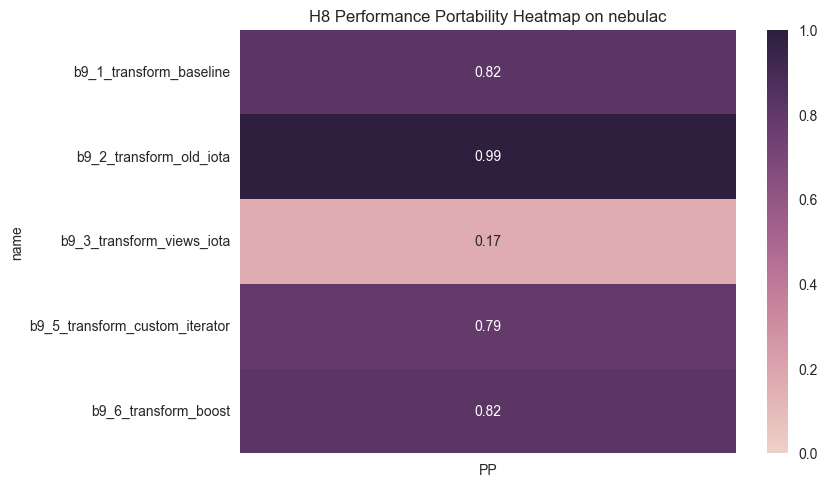

In [46]:
import seaborn as sns

heatmap_pp_df = pp_df.copy()
heatmap_pp_df = heatmap_pp_df.drop(columns=['GCC(TBB)','NVC(OMP)','INTERPRET'])
heatmap_pp_df = heatmap_pp_df.set_index(['name'])


sns.heatmap(heatmap_pp_df, annot=True,cmap=sns.cubehelix_palette(as_cmap=True),vmin=0,vmax=1)

plt.title(f'H8 Performance Portability Heatmap on {device_name}')

plot(f'H8 Performance Portability Heatmap on {device_name}')

## Runtime difference between types

In [47]:
print('========= GCC(TBB) =========')

print('= ALL')
all_gcc_tbb = pp_df['GCC(TBB)']

print('\tStddev:',all_gcc_tbb.std())
print('\tPerformance Portability between types of indices:',calc_pp(all_gcc_tbb.tolist()))

print()
print('= ONLY EFFICIENT')
only_efficient = pp_df[pp_df['name'] != 'b9_2_transform_old_iota']['GCC(TBB)']

print('\tStddev:',only_efficient.std())
print('\tPerformance Portability between types of indices:',calc_pp(only_efficient.tolist()))



========= GCC(TBB) =========
= ALL
	Stddev: 72095030.26308589
	Performance Portability between types of indices: 0.13718967744750493

= ONLY EFFICIENT
	Stddev: 20742938.690167956
	Performance Portability between types of indices: 0.3865461642836478


In [48]:
print('========= NVC(OMP) =========')

print('= ALL')
all_gcc_tbb = pp_df['NVC(OMP)']

print('\tStddev:',all_gcc_tbb.std())
print('\tPerformance Portability between types of indices:',calc_pp(all_gcc_tbb.tolist()))

print()
print('= ONLY EFFICIENT')
only_efficient = pp_df[pp_df['name'] != 'b9_2_transform_old_iota']['NVC(OMP)']

print('\tStddev:',only_efficient.std())
print('\tPerformance Portability between types of indices:',calc_pp(only_efficient.tolist()))


========= NVC(OMP) =========
= ALL
	Stddev: 76459404.7940253
	Performance Portability between types of indices: 0.1115965100618903

= ONLY EFFICIENT
	Stddev: 266541.10319361003
	Performance Portability between types of indices: 0.9492657264174397


## Findings for H8

### XXX

### General


### GPU Findings


### Hypothesis Findings


